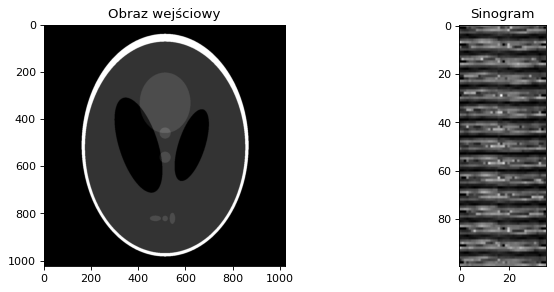

In [84]:
from skimage import io
from matplotlib import pylab as plt
import numpy as np

# input parameters
alfa = 5
detectors = 100 
phi = 90
    
def applyRadonTransform(image):  # doesn't work yet
    sinogram_image = []
    
    for angle in range(0, 180, alfa):
        em_pos = getEmitterPosition(image, angle)
        det_pos = getDetectorsPositions(image, angle)
        
        detectors_output = []
        
        for det in det_pos:
            pixels_sum = 0
            line = applyBresenhamAlgorithm(em_pos[0], em_pos[1], det[0], det[1])
            
            for point in line:
                pixels_sum += image[point[0], point[1]]
                
            detectors_output.append(pixels_sum)
        
        sinogram_image.append(detectors_output)
        
    return sinogram_image

def applyBresenhamAlgorithm(x0, y0, x1, y1): # to draw line primitives (emitter - detector)
    delta_x = x1 - x0
    delta_y = y1 - y0    
    
    x_direction = 1
    y_direction = 1
    
    line = []
    
    if delta_x < 0:
        delta_x, x_direction = abs(delta_x), -1     
                                                       
    if delta_y < 0:
        delta_y, y_direction = abs(delta_y), -1    
    
    error = delta_y - delta_x 
    y = y0 
    x = x0 
        
    if delta_x > delta_y:
        for _ in range(delta_x):
            line.append([x, y])
            if error >= 0:
                y += y_direction
                error -= delta_x
            x += x_direction
            error += delta_y
    else:
        for _ in range(delta_y):
            line.append([x, y])
            if error >= 0:
                x += x_direction
                error -= delta_y
            y += y_direction
            error += delta_x
    
    return line

def getEmitterPosition(image, angle):     # radiany czy stopnie
    angle = np.deg2rad(angle)
    r = max(image.shape) * np.sqrt(2) / 2 
    x = int(r * np.cos(angle)) 
    y = int(r * np.sin(angle))
    
    return x, y

def getDetectorsPositions(image, angle):  
    angle = np.deg2rad(angle)
    positions = []
    r = max(image.shape) * np.sqrt(2) / 2 
    
    for i in range(detectors):
        x = int(r * np.cos(angle + np.pi - phi / 2 + i * (phi / (detectors - 1)))) 
        y = int(r * np.sin(angle + np.pi - phi / 2 + i * (phi / (detectors - 1))))
        positions.append([x, y])
    
    return positions

def normalize():
    return

def applyConvolution(): # to na 5
    return

def displaySinogram():
    return
    
def displayOutput():
    return

def main():
    images = ['Kolo.jpg', 'Kropka.jpg', 'Kwadraty2.jpg', 'Paski2.jpg', 'Shepp_logan.jpg']
    image = io.imread('tomograf-zdjecia/' + images[4], as_gray = True)
    
    sinogram = np.array(applyRadonTransform(image)).transpose()
    
    fig = plt.figure(figsize=(10, 4), dpi=80)   
    ax = fig.add_subplot(121)
    ax.set_title('Obraz wejściowy')
    ax.imshow(image, cmap = 'gray')
    
    ax = fig.add_subplot(122)
    ax.set_title('Sinogram')
    ax.imshow(sinogram, cmap = 'gray')

if __name__ == '__main__':
    main()